In [1]:
import numpy as np 
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


## 1.1


In [8]:
#Variables 
n = 1000
K = 10
R = 10
d=2
pi = .1

In [9]:
def GMDistribution(n, d, K, R, pi):
    z = np.random.randint(1, 11, n)
    ind = np.arange(1,11)
    x, y = (R*np.cos((2*np.pi * ind)/K)).reshape(-1, 1), (R*np.sin((2*np.pi * ind)/K)).reshape(-1,1)
    mu = np.hstack((x, y))
    dist = [multivariate_normal(mean=m) for m in mu]
    samples = np.array([dist[i-1].rvs() for i in z])
    return samples, mu, dist

In [10]:
data, true_means, dist = GMDistribution(7000, d, K, R, pi)
samples, train, test = data[:5000], data[5000:6000], data[6000:]

In [11]:
def EM_GMM(K, samples, tol, max_itr=1000, random_init=False):
    #randomly initialize parameters
    N = samples.shape[0]
    if random_init:
        mu = np.random.random(size=(K,2)) * 30 - 15
    else:
        mu = KMeans(n_clusters=K).fit(samples).cluster_centers_
    
    pi = np.random.randint(1,high=11,size=K)
    pi = pi/pi.sum()
    #construct component distributions for random params
    dist = [multivariate_normal(mean=m) for m in mu]
    #Eval likelihood components wise, then summed per sample, then overall
    likelihoods = np.array([[pi[i]*dist[i].pdf(x) for i in range(K)] for x in samples])
    sample_likelihood = np.sum((likelihoods), axis = 1)
    total_likelihood = np.sum(np.log(sample_likelihood))
    # update parameters
    responsibilities = likelihoods/ sample_likelihood.reshape(-1,1)
    N_k = np.sum(responsibilities, axis=0).reshape(-1, 1)
    mu_next = (1/N_k)*(responsibilities.T@samples)
    pi_next = N_k/N
    error = np.inf
    itr = 1
    while error>tol and itr < max_itr:
        #Loop while error is below tolerance 
        mu = mu_next
        pi = pi_next
        dist = [multivariate_normal(mean=m) for m in mu]
        likelihoods_n = np.array([[pi[i]*dist[i].pdf(x) for i in range(K)] for x in samples]).squeeze()
        sample_likelihood_n = np.sum(likelihoods_n, axis = 1)
        total_likelihood_n = np.sum(np.log(sample_likelihood_n))
        responsibilities = likelihoods_n/ sample_likelihood_n.reshape(-1,1)
        N_k = np.sum(responsibilities, axis=0).reshape(-1, 1)
        mu_next = (1/N_k)*(responsibilities.T@samples)
        pi_next = N_k/N
        error = np.abs(total_likelihood-total_likelihood_n)
        if itr%10 == 0:
            print(error)
        total_likelihood = total_likelihood_n
        itr += 1
        
    return mu, error, pi_next, responsibilities

In [12]:
means, err, pis, responsibilities = EM_GMM(10, train, 1e-12)

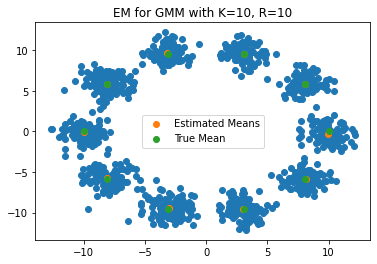

In [13]:
plt.title(f"EM for GMM with K={K}, R={R}")
plt.scatter(train[:,0], train[:,1])
plt.scatter(means[:,0], means[:,1], label="Estimated Means")
plt.scatter(true_means[:, 0], true_means[:, 1], label = "True Mean")
plt.legend()
plt.savefig("./EM_R10")
plt.show()


In [15]:
samples2, true_means2, dist2 = GMDistribution(n, d, K, 1, pi)
means2, err2, pis2, rs2, = EM_GMM(10, samples2, 1e-3)

0.1595812337168354
0.05620822114087787
0.02223982738360064
0.010008417398239544
0.005333568248261145
0.0034516365130912163
0.0026580403364278027
0.0023065219907039136
0.0021383275070547825
0.002042177714429272
0.0019652814521577966
0.0018804611054292764
0.0017745328227647406
0.001644123994083202
0.0014931960317881021
0.0013302815805218415
0.0011654264312710438
0.0010075977056658303


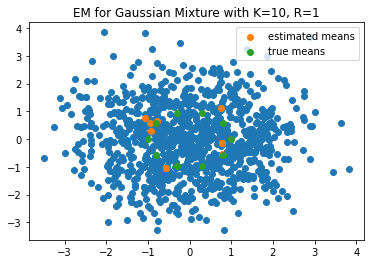

In [16]:
plt.title(f"EM for Gaussian Mixture with K={K}, R={1}")
plt.scatter(samples2[:,0], samples2[:,1])
plt.scatter(means2[:, 0], means2[:,1], label="estimated means")
plt.scatter(true_means2[:, 0], true_means2[:, 1], label="true means")
plt.legend()
plt.savefig("./EM_R1")
plt.show()

##  1.2

In [17]:
kde_train = np.concatenate((samples[:1000], train))

In [18]:
splitter = KFold(n_splits=2)
model = KernelDensity()
parameters = {'bandwidth':np.arange(.1, 2, .01)}
search = GridSearchCV(model, parameters, cv=splitter)
res = search.fit(kde_train)

In [19]:
x = [band['bandwidth'] for band in res.cv_results_['params']]
y = res.cv_results_['mean_test_score']/train.shape[0]
best_estimator = res.best_estimator_
best_score = res.best_estimator_.score(test)/train.shape[0]
best_h = res.best_estimator_.bandwidth

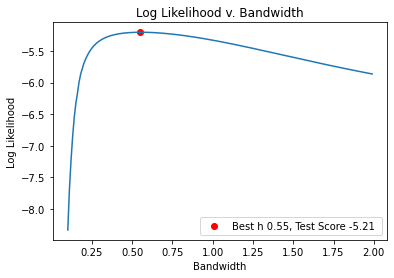

In [20]:
plt.title("Log Likelihood v. Bandwidth")
plt.xlabel("Bandwidth")
plt.ylabel("Log Likelihood")
plt.scatter(best_h, max(y),c='r', label=f"Best h {best_h:.2f}, Test Score {best_score:.2f} ")
plt.plot(x, y)
plt.legend()
plt.savefig("./likelihood_kde")
plt.show()

## 1.6

In [21]:
# Generate Data 
data, true_means, dist = GMDistribution(7000, d, K, R, pi)
samples, train, test = torch.Tensor(data[:5000]), torch.Tensor(data[5000:6000]), torch.Tensor(data[6000:]) 

In [52]:
class GMM_NN(nn.Module):
    def __init__(self):
        super(GMM_NN, self).__init__()
        self.l1 = nn.Linear(2, 50)
        self.l2 = nn.Linear(50, 100)
        self.l3 = nn.Linear(100, 30)
        self.l4 = nn.Linear(30, 1)

    def forward(self, input):
        out = F.relu(self.l1(input))
        out = F.relu(self.l2(out))
        out = F.relu(self.l3(out))
        out = self.l4(out)
        return out

In [53]:
def likelihood(dist, sample):
    prob = np.array([sum([d.pdf(x)*.1 for d in dist]) for x in sample])
    return prob


In [54]:
def partition_loss(E_out, partition):
    return -(E_out - partition).sum()

In [62]:
#Params
Epochs = 70
model = GMM_NN()
criterion = partition_loss
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
pbar = tqdm(range(Epochs))

  0%|          | 0/70 [00:00<?, ?it/s]

In [63]:

loss_trace = []
for e in pbar:
    total_loss = 0.
    like= torch.Tensor(likelihood(dist, samples)).reshape(-1, 1)
    energies = model(samples)
    sample_energies = torch.exp(energies)
    summand = sample_energies/like
    log_partition = summand.mean()
    for x in train:

        out = model(x)
        loss = criterion(out, log_partition)
        total_loss += loss
        
    avg_epoch_loss = total_loss.item()/train.shape[0]
    loss_trace.append(avg_epoch_loss)
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    if len(loss_trace) > 3 and loss_trace[-1]>loss_trace[-2]:
        break
    pbar.set_postfix({'loss':avg_epoch_loss})

 60%|██████    | 42/70 [00:56<00:37,  1.35s/it, loss=7.67]


In [64]:
def var_like(model,test, samples, dist):
    like= torch.Tensor(likelihood(dist, samples)).reshape(-1, 1) #q(x_m)likelihood of data drawn from dist
    energies = model(samples) #E(x_m)energies of data drawn from dist
    test_energies = model(test) #E(x_i)
    sample_energies = torch.exp(energies) #numerator in sample estimator
    summand = sample_energies/like
    log_partition = summand.mean() #A(theta)
    variational_likelihood = (test_energies - log_partition).mean()
    return variational_likelihood


In [66]:
# test Likelihood
var_like(model, test, samples, dist)

tensor(-7.7232, grad_fn=<MeanBackward0>)

# 2.2

In [67]:
from scipy.stats import norm

In [68]:
x = np.linspace(-3,3)
normal_draws = norm.pdf(x, loc=1, scale = .4)
double_normal = norm.pdf(x, loc = 1,scale=.5)+norm.pdf(x, loc = -1,scale=.5)

In [69]:
def kl_div(p, q):
    vals = [p_i* np.log(p_i/q_i) if p_i and q_i > 0 else 0 for p_i, q_i in zip(p, q)]
    return sum(vals)

In [70]:
q_p, p_q = kl_div(normal_draws, double_normal).sum(), kl_div(double_normal, normal_draws).sum()

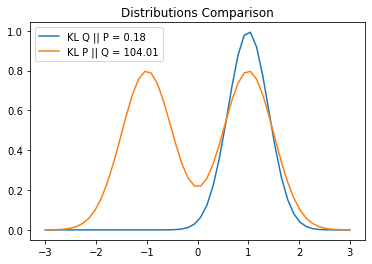

In [71]:
plt.plot(x, normal_draws, label=f"KL Q || P = {q_p:.2f}")
plt.plot(x, double_normal, label = f"KL P || Q = {p_q:.2f}")
plt.title(f"Distributions Comparison")
plt.legend()
plt.savefig('./KL_compare')
plt.show()
